[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [4]:
import os
from dotenv import load_dotenv, find_dotenv

langsmith_key = os.getenv("LANGSMITH_API_KEY")
_ = load_dotenv(find_dotenv())

# login LANGSMITH
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

## Messages as state

First, let's define some messages.

In [5]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [7]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model="gpt-oss:20b-cloud")
llm.invoke(messages)

AIMessage(content='You’ve already got whales covered, but ocean‑mammals are a wide and fascinating kingdom. Below is a quick “cheat sheet” of other groups you might dig into, along with a few standout species and why they’re especially interesting to study.\n\n| Group | Main Families / Orders | Representative Species | Why They’re Cool to Study |\n|-------|-----------------------|------------------------|------------------------|\n| **Cetaceans** | *Delphinidae* (dolphins & killer whales), *Phocoenidae* (porpoises), *Monodontidae* (narwhal, beluga), *Ziphiidae* (beaked whales) | Bottlenose dolphin, Killer whale, Narwhal, Blue whale (though a whale) | Advanced echolocation and complex social systems. Some, like beaked whales, are poorly understood due to remote habitats. |\n| **Pinnipeds** (seals, sea lions, walruses) | *Otariidae* (sea lions & fur seals), *Phocidae* (eared & earless seals), *Odobenidae* (walruses) | California sea lion, Harbor seal, Walrus, Emperor penguin‑like seals |

We can run our chat model in a simple graph with `MessagesState`.

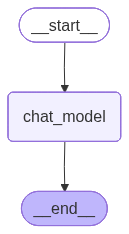

In [8]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Great to hear you’re already into whales! The ocean is home to a fascinating array of mammals, each with its own quirks and stories. Below is a mix of the most iconic, the least‑known, and the “wow‑factor” species that often get overlooked. Pick whichever tickles your curiosity next (or read them all—no rush!).

| Species | Family | Key Highlights | Why It’s Worth a Look |
|---------|--------|----------------|------------------------|
| **Blue Whale** (*Balaenoptera musculus*) | Balaenopteridae | Largest mammal ever. | Classic, but you can dive into its heart‑pump physiology, migration patterns, and impact from c

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

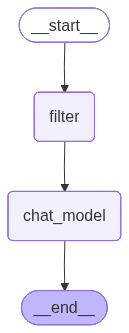

In [10]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

### Beyond the Whale: A Quick Guide to Other Ocean‑Mammals to Explore

| Group | Representative Species | What Makes Them Exciting to Study | Key Research Questions |
|-------|------------------------|----------------------------------|------------------------|
| **Cetaceans (besides whales)** | *Delphinidae* – e.g., *Delphinus delphis* (common dolphin), *Tursiops truncatus* (bottlenose dolphin) | Highly social, superb echolocation, complex cultures | • How do dolphins maintain multi‑generational social units?<br>• What are the neural mechanisms underlying their acoustic intelligence? |
| **Porpoises** | *Phocoen

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

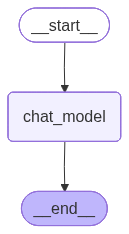

In [12]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [13]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [14]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

### Beyond the Whale: A Quick Guide to Other Ocean‑Mammals to Explore

| Group | Representative Species | What Makes Them Exciting to Study | Key Research Questions |
|-------|------------------------|----------------------------------|------------------------|
| **Cetaceans (besides whales)** | *Delphinidae* – e.g., *Delphinus delphis* (common dolphin), *Tursiops truncatus* (bottlenose dolphin) | Highly social, superb ech

In [15]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

### Beyond the Whale: A Quick Guide to Other Ocean‑Mammals to Explore

| Group | Representative Species | What Makes Them Exciting to Study | Key Research Questions |
|-------|------------------------|----------------------------------|------------------------|
| **Cetaceans (besides whales)** | *Delphinidae* – e.g., *Delphinus delphis* (common dolphin), *Tursiops truncatus* (bottlenose dolphin) | Highly social, superb ech

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

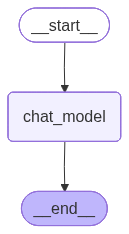

In [23]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOllama(model="gpt-oss:20b-cloud"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [20]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOllama(model="gpt-oss:20b-cloud"),
            allow_partial=False
        )

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1715 > 1024). Running this sequence through the model will result in indexing errors


[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [24]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r